In [1]:
import matplotlib.pyplot as plt
import csv
import pandas
from matplotlib.backends.backend_pdf import PdfPages
import seaborn
import numpy as np
from pandas.plotting import autocorrelation_plot
seaborn.set()
seaborn.set_style("whitegrid")

The following sets some constants, for comparison

In [149]:
BYTE = 8
GIGA = 1024 * 1024 * 1024
BWM_NG_HEADERS = ["timestamp",
                               "interface", 
                               "bytes_out/s", 
                               "bytes_in/s",                                
                               "bytes_total/s", 
                               "bytes_in", 
                               "bytes_out", 
                               "packets_out/s", 
                               "packets_in/s", 
                               "packets_total/s", 
                               "packets_in", 
                               "packets_out", 
                               "errors_out/s", 
                               "errors_in/s", 
                               "errors_in", 
                               "errors_out "]
BWM_NG_ARGS = {
    "names": BWM_NG_HEADERS,
    "converters": 
           {'timestamp': lambda ts: pandas.to_datetime(ts, unit='s')},
    "sep": ';',
    "header": None
    }

Read the bandwidth measurements:

In [150]:
with open("bw_nfs_measure.csv", "r") as fp:
    df = pandas.read_csv(fp, **BWM_NG_ARGS)
    df = df[df['interface'] == 'ens3']
    df = df[:-1500] # Drop the boring samples at the end 
    df['gbit/s'] =  df['bytes_out/s'] * BYTE / GIGA
    df.set_index('timestamp', inplace=True)

Convert it to a time series and compute rolling medians across it:

In [142]:
ts = pandas.Series(df['gbit/s'])

rolling = ts.rolling(center=False, window=50).median()

Export it as a PDF plot for the report:

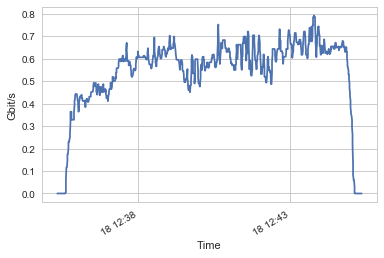

In [143]:
with PdfPages("latex_report/rolling.pdf") as pp:
    ax = rolling.plot()
    #ax.set_ybound(0, 1)
    ax.set_ylabel("Gbit/s")
    ax.set_xlabel("Time")
    pp.savefig()

Compute an autocorrelation plot of the data:

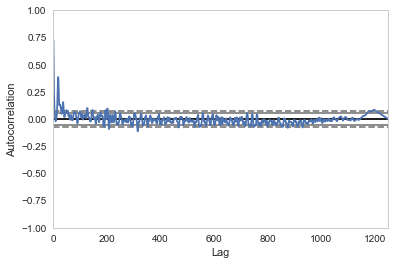

In [144]:
autocorrelation_plot(ts)

Compute the density function of the transfer speed:

Text(0.5,0,'Gbit/s')

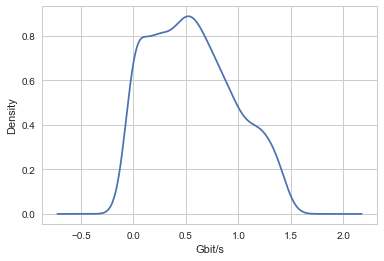

In [145]:
ax = df['gbit/s'].plot.kde()
ax.set_xlabel("Gbit/s")

## Result analysis
The following cells analyse the results of the measurements.

In [191]:
FORMAT_OPTIONS = {'sep': ";", 'header': None, 
                  'names': ["start time", "end time",
                            "workers", "runtime"],
                  "converters": 
                   {'start time': lambda ts: pandas.to_datetime(ts, unit='s'),
                    'end time': lambda ts: pandas.to_datetime(ts, unit='s')},
}
with open("runtimes.hdfs", "r") as fp:
    hdfs_runtimes = pandas.read_csv(fp, **FORMAT_OPTIONS)

First, perhaps most importantly, we need to calculate the standard error mean (in seconds):

In [192]:
def get_errors(result_df):
    return pandas.DataFrame(
        [{'workers': w, 
          'error': result_df[result_df['workers'] == w].sem()['runtime']}
         for w in range(4, 11)])

In [193]:
with open("runtimes.nfs", "r") as fp:
    nfs_runtimes = pandas.read_csv(fp, **FORMAT_OPTIONS)

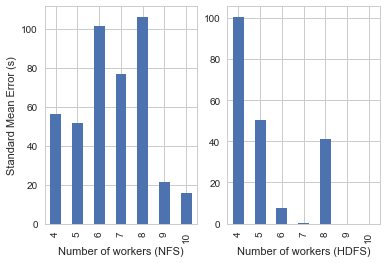

In [194]:
with PdfPages("latex_report/errors.pdf") as pp:
    fig, (axsl, axsr) = plt.subplots(1, 2)
    get_errors(nfs_runtimes).plot.bar("workers", ax=axsl)
    get_errors(hdfs_runtimes).plot.bar("workers", ax=axsr)
    axsl.set_ylabel("Standard Mean Error (s)")
    axsr.set_xlabel("Number of workers (HDFS)")
    axsl.set_xlabel("Number of workers (NFS)")
    axsl.legend([])
    axsr.legend([])
    pp.savefig()

Plot the results. Note that the `x_estimator` argument collects multiple data points and adds error bars to the plot!

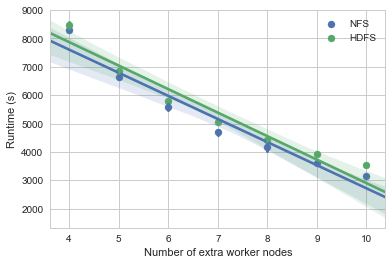

In [229]:
with PdfPages("latex_report/scaling.pdf") as pp:
    fig, ax = plt.subplots(1, 1)
    CHART_OPTIONS = {'x': "workers", 'y': "runtime",
                     'x_estimator': np.mean, 'ax': ax}
    seaborn.regplot(data=nfs_runtimes, label="NFS", **CHART_OPTIONS)
    seaborn.regplot(data=hdfs_runtimes, label="HDFS", **CHART_OPTIONS);
    ax.legend()
    ax.set_xlabel("Number of extra worker nodes")
    ax.set_ylabel("Runtime (s)")
    pp.savefig()

In [299]:
def get_difference(hdfs_df, nfs_df):
    return pandas.DataFrame(
        [{'workers': w, 
          'Difference %': 100 * (hdfs_df[hdfs_df['workers'] == w].median()['runtime']
             - nfs_df[nfs_df['workers'] == w].median()['runtime']) / 
          nfs_df[nfs_df['workers'] == w].median()['runtime']}
         for w in range(4, 11)])

get_difference(hdfs_runtimes, nfs_runtimes)

,Difference %,workers
0,2.256295,4
1,3.599632,5
2,3.918208,6
3,8.066933,7
4,6.659424,8
5,8.716939,9
6,11.927596,10


### Network Traffic Analysis
Now, we proceed to read in the network traffic statistics caputured by `bwm-ng`.

In [ ]:
netdata = {}
for name in ["dataset-download", *[str(n) for n in range(0, 12)]]:
    with open("bandwidth-measurements-group-2-project-{}.xz"
              .format(name), "rb") as fp:
        try:
            df = pandas.read_csv(fp, sep=";", header=None, compression='xz', 
                                 names=BWM_NG_HEADERS)
        except EOFError as e:
                pass
        df = df[df['interface'] == 'ens3']
        netdata[name] = df

In [203]:
with open("bw1.csv", "rb") as fp:
    df = pandas.read_csv(fp, **BWM_NG_ARGS)
    df = df[df['interface'] == 'ens3']
    #df.set_index('timestamp', inplace=True)

In [197]:
ten_starts = hdfs_runtimes[hdfs_runtimes['workers'] == 10]['start time']
ten_ends = hdfs_runtimes[hdfs_runtimes['workers'] == 10]['end time']

In [221]:
def slice_time_interval(df, start, end):
    return df[df['timestamp'] >= start][df['timestamp'] <= end]

In [222]:
start, end = (list(ten_starts)[0], list(ten_ends)[0])
xs = slice_time_interval(df, start, end)

/Users/albin/anaconda/envs/ldsa/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [224]:
# nfs: 
# for each cluster size, a plot (subfigure):
#   show out for the server during the run, in for each node (one line each) over time

# hdfs:
# for each cluster size, a plot (subfigure):
#   show median values for in and out for each node (one bar in, one line out)

# sum network packages sent and received for hdfs
# sum network packages sent and received for nfs

115235.53

In [228]:
help(seaborn.regplot)

Help on function regplot in module seaborn.regression:

regplot(x, y, data=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=False, dropna=True, x_jitter=None, y_jitter=None, label=None, color=None, marker='o', scatter_kws=None, line_kws=None, ax=None)
    Plot data and a linear regression model fit.
    
    There are a number of mutually exclusive options for estimating the
    regression model: ``order``, ``logistic``, ``lowess``, ``robust``, and
    ``logx``. See the parameter docs for more information on these options.    
    
    Parameters
    ----------
    x, y: string, series, or vector array
        Input variables. If strings, these should correspond with column names
        in ``data``. When pandas objects are used, axes will be labeled with
        the series name.
    data : DataFrame
        Tidy ("long-for